<h1><center> Predicting Used Cars' Prices (Part II) </center></h1>

This is second part of my third quarantine project. The objective of this work is to predict the used car prices listed on craigslist based on their features posted in the ad. You can click [here](https://github.com/suatakbulut/QuarantineProjects/tree/master/Prediction%20Modeling%20Projects/Used%20Car%20Price%20Estimator/Part%201) to see the first part, where I performed an exploratory data analysis to better understand the data set and then build four different machine learning model to predict the used car prices. I compare the models based on their mean absolute error (MAE). 

In this part of the project, I use webscraping tools in order to obtain the MSRP values of the cars in my data set.  In order to simplify the work, I only scrape the base model MSRPs. That is to say, all different trims of a car are considered as same as the base model. I have scraped MSRP values from two different sources, [NewCarTestDrive.com](https://www.newcartestdrive.com/) and [GoogleSearch](https://www.google.com/). The former is easier to scrape since it does not have any requests limit, however, it has MSRP values for only around one third of the the cars in our data set. 

After obtaining the MSRP values, I follow the same outlier removal, data cleaning, and preprocessing procedure as Part 1. I later run **Random Forest Regressor**, **Linear Regression**, **K-Neighbors Classifier**, and **XGBoost Regressor** models with both default and optimized hyper parameters. Then I compare the Mean Average Errors with the ones obtained in Part 1. Results are shown in the table below. 

| Model                   | No MSRP | MSRP - Default Model| MSRP - Optimized Model |
| :----------------------:|:-------:|:-------------------:|:----------------------:|
| Random Forest Regressor | 1440.50 |       1216.465      |        1324.336        |
| Linear Regression       | 2341.04 |       1860.074      |        1860.074        |
| K-Neighbors Classifier  | 2600.55 |       2242.878      |        2352.738        |
| XGB Regressor           | 2793.04 |       2347.572      |        1917.165        |

For the sake of fairness of comparison, the data is first split into train and test sets. In the first two cases, No MSRP and MSRP without optimization, models are trained on train set and Mean Absolute Errors calculated based on their performance on test set. For optimization, however, the train set is split into train and validation sets. Models are trained on the trained set, optimized based on their performances on the validation set and finally the optimized versions are tested on the test set. Above is their Mean Absolute Errors on the test set. One might consider training the optimized models on the initial larger train set, however, it could result in over-fitting. 

Following is the structure of the notebook, you can simply jump to the section by clicking on its name. 

0. [Packages and Functions](#packages_functions_link)
1. [Webscraping](#scrape_link)
    1. [NewCarTestDrive.com](#scrape_newcar_link)
    2. [GoogleSearch](#scrape_google_link)
2. [X and y](#data_consolidation_link)
3. [Machine Learning](#machine_learning_link)
    1. [Preprocessing Data](#preprocessing_data_link)        
    2. [Modeling (Without Optimization)](#unoptimizedmodeling_link)
        1. [Random Forest Regression](#forest_model_link)
        2. [Linear Regression](#lin_model_link)
        3. [kNN Classifier](#knn_model_link)
        4. [XG Boost](#xgb_model_link)
    3. [Model Comparison](#model_comparison_link)
    4. [Model Optimization](#optimization_link)
        1. [Optimizing Random Forest Regressor](#optimizing_forest_link)
        2. [Optimizing kNN Classifier](#optimizing_knn_link)
        3. [Optimizing XGB Regressor](#optimizing_xgb_link)
    5. [Comparing Optimized Models](#optimizing_comparison_link)
4. [Conclusion](#conclusion_link)

<a id="packages_functions_link"></a>
# 0. Packages and Functions

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
from time import time

from matplotlib import pyplot as plt
import seaborn as sns
import warnings

import requests
from bs4 import BeautifulSoup
import re
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import selenium.webdriver.chrome.service as serv

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import OneHotEncoder

# to evaluate and compare our models' predicition power
from sklearn.metrics import mean_absolute_error

import scipy.sparse

Now let us create the following functions. We will use getMSRP(), getCarName(), scrapeNewCarsTestDrive(), and scrapeGoogleSearch() in scraping the MSRP values and removeOutlier() in handling the outliers in price and odometer values. 

In [34]:
################
# FNCT 1
################
pattern = re.compile(r"\$\d+[,]\d\d\d")
def getMSRP(text):
    """
    Returns the first subtext that matches the pattern if it can. 
    Otherwise, it returns None
    """
    try:
        result = pattern.search(text)
        msrp = result.group()
        MSRP = msrp.replace(",","")
        return MSRP[1:] 
    except:
        return None

################
# FNCT 2
################
def getCarName(row):    
    """
    given a row of a pandas df that has the columns year, manufacturer, and model,
    returns a new text variable formatted as year-maker-model
    """
    raw_name = str(int(row.year)) + " " + str(row.manufacturer) +" "+ str(row.model)
    name = raw_name.split(" ")
    carName = "-".join(name[:3])
    return carName.replace(",","")

################
# FNCT 3
################
def scrapeNewCarsTestDrive(CarName):
    """ 
    Takes a string formatted as maker-model-year.
    If newcartestdrive.com/reviews has the MSRP value, Returns a string:
        CarName, CarMSRP
    """
    try:
        url = "https://www.newcartestdrive.com/reviews/{}/".format(CarName)
        response = requests.get(url)
        urlSoup = BeautifulSoup(response.content, "html.parser")
        
        try:
            # Sometimes the Model LineUp is in the table at the bottom    
            specTable = urlSoup.find("div", attrs={"id":"specs-table"})
            row = specTable.findAll("tr")[1]
            msrpInfo = row.td.nextSibling.text
            carMSRP = getMSRP(msrpInfo)
            line = ",".join([CarName, carMSRP]) + "\n" 
            return line 
        except AttributeError:
            # Sometimes the Model LineUp is in the body of the review article
            # Under the h2 title names Model Lineup
            start = urlSoup.find("h2", text = "Model Lineup")
            end = start.findNext("h2")
            item = start.nextSibling
            
            while item != end: 
                p = str(item)
                if "destination charge" not in p and "option" not in p:
                    carMSRP = getMSRP(p)
                    if type(carMSRP) == str:
                        break
                item = item.nextSibling

            line = ",".join([CarName, carMSRP]) + "\n" 
            return line
    except:
        pass

################
# FNCT 4
################
def scrapeGoogleSearch(CarName): 
    """ 
    Takes a string formatted as maker-model-year.
    If google.com/search has the MSRP value in the first main div block called g.mnr-c.g-blk
    Returns a string: CarName, CarMSRP
    """
    try:        
        query = "+".join([CarName.replace("-", "+"), "msrp"])
        url = "https://google.com/search?q=<{}>".format(query) 
        driver.get(url) 
        
        carPage = driver.find_element_by_class_name("g.mnr-c.g-blk")
        carHTML = driver.execute_script('return arguments[0].innerHTML', carPage)
        carSoup = BeautifulSoup(carHTML, 'html.parser')

        if "MSRP" in carSoup.text:
            carMSRP = getMSRP(carSoup.text)
            line = ",".join([CarName, carMSRP]) + "\n"
            return line
    except:
        pass

################
# FNCT 5
################
def removeOutlier(df, col):  
    """
    Takes a dataframe and column name (str) as input
    Returns a subset of the dataframe after eliminating the
    observations for which value under col column is an 
    outlier based on IQR method
    """  
    quant1 = df[col].quantile(0.25)
    quant3 = df[col].quantile(0.75)
    iqr = quant3 - quant1
    filtered = df.loc[(df[col] >= quant1 - 1.5*iqr) & (df[col] <= quant1 + 1.5*iqr)]
    
    return filtered

<a id="scrape_link"></a>
# 1. WebScraping

I have scraped MSRP values from two different sources, NewCarTestDrive.com and GoogleSearch. The former is easier to scrape since it does not have any requests limits, however, it has MSRP values for only around one third of the cars in our data set. 

Scraping takes soo long. So, instead of running the code again here, I will share the code and load the data that I have already scraped. 

In [5]:
# Load all cars
carsAll = pd.read_csv("vehicles.csv")

# Exclude the cars manufactured before 2000.
cars = carsAll.loc[carsAll.year >= 2000].copy()

# Drop those observations missing one of the year, maker, or model infromation
cars = cars.dropna(subset = ["year", "manufacturer", "model"]).reset_index(drop=True)

# Create CarName column
cars["CarName"] = cars.apply(lambda row: getCarName(row), axis=1)

# List of all year-manufacturer-model combinations
CarNames = set(cars.CarName.unique())

<a id="scrape_newcar_link"></a>
## 1.A. NewCarTestDrive.com

[NewCarTestDrive.com](https://www.newcartestdrive.com/) has a nice database where they provide reviews about new cars. 
At the bottom of their reviews, they sometimes have a nice summary table where they show the MSRP value of the reviewed car. However, even if they don include the summary table, they always have a Model Lineup paragraph in which they mention about the MSRP values for different trims of reviewed car. 

Fow instance, when we look at the review of 2015 RAM Promaster below, we have both summary table and Model Lineup paragraph. In order to simplify the work, I will only retrieve the base model MSRP, the lowest one. 

<img src=msrp.PNG>

However, they do not have this information for all the cars in our dataset. Moreover, for some cars, they do not provide the MSRP value at all. Hence, out of 11,461 different year-maker-model combinations in our data set, I have scraped only 3,561 MSRPs. 

**Code for scraping NewCarTestDrive.com. I use requests and BeautifulSoup packages for this part.**

```python
print("====================================================================")
print("{:^68}".format("MSRP scraping from NewCarTestDrive.com started."))
print("====================================================================")

# Save the scraped ones in Scraped set, so that 
# next time we will scrape the reamaining cars
Scraped = set()
startTime = time()
# Save the information scraped into a csv file
f = open("MSRPs_NewCarTestDrive.csv", "w")
header = "CarName,BaseMSRP\n"
f.write(header)

for CarName in CarNames:
    line = scrapeNewCarsTestDrive(CarName)
    if line != None:
        f.write(line)
        # Since it is a success, save the CarName to Scraped
        Scraped.add(CarName)

f.close()
endTime = time()
runTime = (endTime - startTime) // 60

print("====================================================================")
print("{:^68}".format("MSRP scraping from newcartestdrive.com completed. It took {} mins.".format(runTime)))
print("====================================================================")
```

<a id="scrape_google_link"></a>
## 1.B. GoogleSearch

For the rest of the observations in my data set, I will scrape google search. When I search year+maker+model+"MSRP" in Google Search Bar, it usually returns the following block at the top of the results, which I will be searching for MSRP once I get the requested page. 

<img src=googleSearch.PNG width=500>

Unlike NewCarTestDrive.com, Google does not allow Too Many Requests. Therefore, for every 600 requests, I make the code sleep for two hours. Just like before, for all trims of a model, I will use the same base model MSRP. This is only for simplicity. Once can easily extend it to all different trims. out of 7,900 different remaining year-maker-model combinations in our data set, I have scraped 5,918 MSRPs with this method. 

**Code for scraping GoogleSearch. I use selenium webdriver with headless chrome service for this part.**

```python
# Set of cars for which MSRP has not been scraped yet
CarsRemaining = CarNames - Scraped 

# use chrome as the service in headless mode
service = serv.Service("chromedriver.exe")
chrome_options = Options()  
chrome_options.add_argument("--headless")
# Initiate webdriver
driver = webdriver.Chrome(options = chrome_options)

count = 0
header = "CarName,BaseMSRP\n"
f =  open("MSRPs_Google.csv", "w")
f.write(header)

for CarName in CarsRemaining:
    count+=1
    if count %600 != 0:            
        line = scrapeGoogleSearch(CarName)
        if line != None:
            f.write(line)
            Scraped.add(CarName)
        
    else:
        driver.quit()
        now = datetime.now()
        currentTime = now.strftime("%H:%M:%S")
        print("====================================================================")
        print("{:^68}".format("# of Google Scrape Attempts: {}. Time is now {}".format(count, currentTime)))
        print("====================================================================")
        # Sleep 2 hours
        time.sleep(60*60*2)
        driver = webdriver.Chrome(options = chrome_options)
```

<a id="data_consolidation_link"></a>
# 2. X and y

In [6]:
# Combine the two scraped tables into one, dfMSRP
dfMSRPGoogle = pd.read_csv("MSRPs_Google.csv", engine="python")
dfMSRPNewCarTestDrive = pd.read_csv("MSRPs_NewCarTestDrive.csv")
dfMSRP = pd.concat([dfMSRPNewCarTestDrive, dfMSRPGoogle]).reset_index(drop=True)

# Now lets merge scraped MSRPs to our cars table using left join
carsMSRP = pd.merge(cars, dfMSRP, on = "CarName", how="left")

# On top of the variabels I used in Part 1, this time I will also use BaseMSRP
cols = ["region", "state", "year", "manufacturer", "model", "odometer", "title_status", "transmission", "type", "condition", "description", "paint_color", "BaseMSRP", "price" ]
dfCars = carsMSRP.loc[carsMSRP.condition != "new"].copy()[cols]

# Similar to Part 1, remove the outliers
dfCars = removeOutlier(dfCars, "price")
dfCars = removeOutlier(dfCars, "odometer")

# If there is an observation that is missing the price value, we drop that observation
cols = ['price', 'state', 'year', 'manufacturer', 'model', 'odometer', 'title_status', 'transmission', 'type', 'condition', 'BaseMSRP']
X_df = dfCars.copy()[cols].dropna(subset=["price"]).reset_index(drop=True)
X_all = X_df.loc[X_df.price > 999]

<a id="machine_learning_link"></a>
# 3. Machine Learning

<a id ="preprocessing_data_link"></a>
## 3.A. Preprocessing Data

In [7]:
# Before the preprocessing step, I will divide my data into training and validation sets
from sklearn.model_selection import train_test_split

y = X_all.price
X = X_all.drop("price", axis=1)

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [8]:
numerical_cols   = [col for col in X.columns if X[col].dtype in ["int64", "float"]]
categorical_cols = [col for col in X.columns if X[col].dtype == "object" ] 

# Preprocessing Numerical data: impute the missing values with the mean and scale the data
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy = "mean")),
    ("scaler", StandardScaler())
])
                    

# Preprocessing Categorical data: impute the missing values with the most frequent one and onehot encode the categories
categorical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ])

# Combine the two type of column preprocessors
preprocessor = ColumnTransformer(
        transformers=[
                ("num", numeric_transformer, numerical_cols),
                ("cat", categorical_transformer, categorical_cols)
                ])


Preprocess will take so long time due to the size of the data and the high number of categories in categorical variables. Therefore, I will do this once and save the sparsematrices. However, next time I run this code I may need a different train test split, hence, I will ask the user if they want to re-preprocess the data. 

In [9]:
# By uncommenting the following line and commanding the one after, we allow user to decide
# preprocess_input = input("Do you want to preprocess data again? (y, n) \nIf you choose yes (y) the data will be re-preprocessed and it takes so loong. ")
preprocess_input = "y"

if preprocess_input != "n":
    # use the raw train data to fit then transform both train and valid data
    X_train = preprocessor.fit_transform(X_train_raw)
    X_test  = preprocessor.transform(X_test_raw)
    
    # Now save them:
    scipy.sparse.save_npz('X_train.npz', X_train)
    scipy.sparse.save_npz('X_test.npz', X_test)
    y_train.to_pickle("y_train.pkl")
    y_test.to_pickle("y_test.pkl")

else:    
    X_train = scipy.sparse.load_npz('X_train.npz')
    X_test  = scipy.sparse.load_npz('X_test.npz') 
    y_train = pd.read_pickle("y_train.pkl")
    y_test  = pd.read_pickle("y_test.pkl")


<a id ="unoptimizedmodeling_link"></a>
## 3.B. Modeling (Without Optimization)

At this stage we are done with preprocessing. Now, we combine preprocessing with our selection of models with the default hyper-parameters (unless n_jobs is an available option) and compare them based on mean absolute error (MAE). 
    1. Linear Regression
    2. kNN Classifier
    3. XG Boost    

<a id ="forest_model_link"></a>
### 3.B.a. Random Forest Regression

In [11]:
from sklearn.ensemble import RandomForestRegressor
warnings.filterwarnings("ignore")

# Initiate the model using the default hyper-parameters
# I use 51 trees instead of 100 since it takes around 6 hours to create 100 trees, 
# moreover, random forest performs waay worse than linear and xgb models
forest_model = RandomForestRegressor(n_estimators = 51, verbose= 3, n_jobs=-1, random_state=0)

# fit data to the model
start_fit = time()
forest_model.fit(X_train, y_train)
end_fit = time()

start_pred = time()
forest_model_preds = forest_model.predict(X_test)
end_pred = time()

forest_model_score = mean_absolute_error(y_test, forest_model_preds)
forest_model_fit_time = end_fit - start_fit
forest_model_pred_time = end_pred - start_pred

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 51
building tree 2 of 51
building tree 3 of 51
building tree 4 of 51
building tree 5 of 51
building tree 6 of 51
building tree 7 of 51
building tree 8 of 51
building tree 9 of 51
building tree 10 of 51
building tree 11 of 51
building tree 12 of 51
building tree 13 of 51
building tree 14 of 51
building tree 15 of 51
building tree 16 of 51
building tree 17 of 51
building tree 18 of 51
building tree 19 of 51
building tree 20 of 51
building tree 21 of 51
building tree 22 of 51
building tree 23 of 51


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.6min


building tree 24 of 51
building tree 25 of 51
building tree 26 of 51
building tree 27 of 51
building tree 28 of 51
building tree 29 of 51
building tree 30 of 51
building tree 31 of 51
building tree 32 of 51
building tree 33 of 51
building tree 34 of 51
building tree 35 of 51
building tree 36 of 51
building tree 37 of 51
building tree 38 of 51
building tree 39 of 51
building tree 40 of 51
building tree 41 of 51
building tree 42 of 51
building tree 43 of 51
building tree 44 of 51
building tree 45 of 51
building tree 46 of 51
building tree 47 of 51
building tree 48 of 51
building tree 49 of 51
building tree 50 of 51
building tree 51 of 51


[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed: 11.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  51 out of  51 | elapsed:    0.4s finished


In [12]:
forest_summary = {
"Model Name" : "Random Forest",
"Mean Absolute Error" : round(forest_model_score,2),
"Model Training Time" : round(forest_model_fit_time, 2),
"Model Prediction Time" : round(forest_model_pred_time, 2)
}

for key in forest_summary.keys():
    print(key, ": ", str(forest_summary[key]))

Model Name :  Random Forest
Mean Absolute Error :  1216.47
Model Training Time :  695.32
Model Prediction Time :  0.57


<a id ="lin_model_link"></a>
### 3.B.b. Linear Regression

In [13]:
from sklearn.linear_model import LinearRegression

# Initiate the linear model with the default parameters
lin_model = LinearRegression(n_jobs=-1)

# fit data to the model
start_fit = time()
lin_model.fit(X_train, y_train)
end_fit = time()

start_pred = time()
lin_model_preds = lin_model.predict(X_test)
end_pred = time()

lin_model_score = mean_absolute_error(y_test, lin_model_preds)
lin_model_fit_time = end_fit - start_fit
lin_model_pred_time = end_pred - start_pred

In [14]:
lin_summary = {
"Model Name" : "Linear Regressor",
"Mean Absolute Error" : round(lin_model_score,2),
"Model Training Time" : round(lin_model_fit_time, 2),
"Model Prediction Time" : round(lin_model_pred_time, 2)
}

for key in lin_summary.keys():
    print(key, ": ", str(lin_summary[key]))

Model Name :  Linear Regressor
Mean Absolute Error :  1860.07
Model Training Time :  61.29
Model Prediction Time :  0.0


<a id ="knn_model_link"></a>
### 3.B.c. kNN Classifier

The price of similar cars are expected to be similar. The only real numeric explanatory variable in our data set is odometer, and the sensitivity of price to odometer is more like a step function. Even though this is a regression question, I will try to use a classification technique in predicting the price of a car looking at the cars in my trainning set that are similar to this car. 

Since we scaled the odometer, the cars that are in the neighborhood of a test car will be more similar in terms of other features such as maker, model, year, type, etc. 

In [15]:
from sklearn.neighbors import KNeighborsClassifier

# Initiate the knn model with the default parameters
knn_model = KNeighborsClassifier(n_jobs=-1)

# fit data to the model
start_fit = time()
knn_model.fit(X_train, y_train)
end_fit = time()

start_pred = time()
knn_model_preds = knn_model.predict(X_test)
end_pred = time()

knn_model_score = mean_absolute_error(y_test, knn_model_preds)
knn_model_fit_time = end_fit - start_fit
knn_model_pred_time = end_pred - start_pred

In [16]:
knn_summary = {
"Model Name" : "KNeighbors Classifier",
"Mean Absolute Error" : round(knn_model_score,2),
"Model Training Time" : round(knn_model_fit_time, 2),
"Model Prediction Time" : round(knn_model_pred_time, 2)
}

for key in knn_summary.keys():
    print(key, ": ", str(knn_summary[key]))

Model Name :  KNeighbors Classifier
Mean Absolute Error :  2242.88
Model Training Time :  0.05
Model Prediction Time :  587.25


<a id ="xgb_model_link"></a>
### 3.B.d. XG Boost Regressor


In [17]:
from xgboost import XGBRegressor

# Initiate the xgb model with the default parameters
xgb_model = XGBRegressor()

# fit data to the model
start_fit = time()
xgb_model.fit(X_train, y_train)
end_fit = time()

start_pred = time()
xgb_model_preds = xgb_model.predict(X_test)
end_pred = time()

xgb_model_score = mean_absolute_error(y_test, xgb_model_preds)
xgb_model_fit_time = end_fit - start_fit
xgb_model_pred_time = end_pred - start_pred

[20:52:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [18]:
xgb_summary = {
"Model Name" : "XG Boost Regressor",
"Mean Absolute Error" : round(xgb_model_score,2),
"Model Training Time" : round(xgb_model_fit_time, 2),
"Model Prediction Time" : round(xgb_model_pred_time, 2)
}

for key in xgb_summary.keys():
    print(key, ": ", str(xgb_summary[key]))

Model Name :  XG Boost Regressor
Mean Absolute Error :  2347.57
Model Training Time :  7.84
Model Prediction Time :  0.35


<a id ="model_comparison_link"></a>
## 3.C. Model Comparison

Now we can compare our models' performances. 

In [19]:
models = pd.DataFrame({
    "Model": ["Random Forest Regressor", "Linear Regression", "K-Neighbors Classifier", "XGB Regressor" ],
    "Score": [forest_model_score, lin_model_score, knn_model_score, xgb_model_score ],
    "Train Time" :[round(t,2) for t in [forest_model_fit_time, lin_model_fit_time, knn_model_fit_time, xgb_model_fit_time ]],
    "Pred Time" : [round(t,2) for t in [forest_model_pred_time, lin_model_pred_time, knn_model_pred_time, xgb_model_pred_time ]]
    })

model_scores = models.sort_values(by="Score").reset_index(drop=True)

print(model_scores)

                     Model        Score  Train Time  Pred Time
0  Random Forest Regressor  1216.465453      695.32       0.57
1        Linear Regression  1860.074411       61.29       0.00
2   K-Neighbors Classifier  2242.878884        0.05     587.25
3            XGB Regressor  2347.572646        7.84       0.35


This time the winner among the non-optimized models is the Linear Regression Model. 

<a id ="optimization_link"></a>
## 3.D. Model Optimization

In this section we try different paramater values for XGB Regressor and K-Neighbors Classifier models in order to optimize them. 

In [22]:
X_tra, X_val, y_tra, y_val = train_test_split(X_train, y_train, test_size = 0.3)

<a id ="optimizing_forest_link"></a>
### 3.D.a. Optimizing Random Forest Regressor

In [27]:
def get_score_forest(n_est):
    forest_model = RandomForestRegressor(n_estimators = n_est, verbose= 3, n_jobs=-1)
    # fit the train data to the model
    forest_model.fit(X_tra, y_tra)

    # Measure the score of our model    
    forest_y_hat = forest_model.predict(X_val)
    forest_score = mean_absolute_error(y_val, forest_y_hat)

    return forest_score

forest_dict = {}
for n_est in range(35,75,8):
    forest_dict[n_est] = get_score_forest(n_est)

n_est_star = min(forest_dict.keys(), key = (lambda k: forest_dict[k]))

forest_model_star = RandomForestRegressor(n_estimators = n_est_star, verbose= 3, n_jobs=-1, random_state=0)
# fit the train data to the model
forest_model_star.fit(X_tra, y_tra)

# Measure the score of our model    
forest_y_predict_star = forest_model_star.predict(X_test)
forest_star_score = mean_absolute_error(y_test, forest_y_predict_star)

print("Optimal n_estimators is {}\nThe MAE of optimized Random Forest model is {}".format(n_est_star, forest_star_score))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 35
building tree 2 of 35building tree 3 of 35

building tree 4 of 35
building tree 5 of 35
building tree 6 of 35
building tree 7 of 35
building tree 8 of 35
building tree 9 of 35
building tree 10 of 35
building tree 11 of 35
building tree 12 of 35
building tree 13 of 35
building tree 14 of 35
building tree 15 of 35
building tree 16 of 35
building tree 17 of 35
building tree 18 of 35
building tree 19 of 35
building tree 20 of 35
building tree 21 of 35
building tree 22 of 35
building tree 23 of 35
building tree 24 of 35


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.0min


building tree 25 of 35
building tree 26 of 35
building tree 27 of 35
building tree 28 of 35
building tree 29 of 35
building tree 30 of 35
building tree 31 of 35
building tree 32 of 35
building tree 33 of 35
building tree 34 of 35
building tree 35 of 35


[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:  4.0min remaining:   22.5s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  4.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  32 out of  35 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  35 out of  35 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 43building tree 2 of 43
building tree 3 of 43

building tree 4 of 43
building tree 5 of 43
building tree 6 of 43
building tree 7 of 43
building tree 8 of 43
building tree 9 of 43
building tree 10 of 43
building tree 11 of 43
building tree 12 of 43
building tree 13 of 43
building tree 14 of 43
building tree 15 of 43
building tree 16 of 43
building tree 17 of 43
building tree 18 of 43
building tree 19 of 43
building tree 20 of 43
building tree 21 of 43
building tree 22 of 43
building tree 23 of 43
building tree 24 of 43


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.0min


building tree 25 of 43
building tree 26 of 43
building tree 27 of 43
building tree 28 of 43
building tree 29 of 43
building tree 30 of 43
building tree 31 of 43
building tree 32 of 43
building tree 33 of 43
building tree 34 of 43
building tree 35 of 43
building tree 36 of 43
building tree 37 of 43
building tree 38 of 43
building tree 39 of 43
building tree 40 of 43
building tree 41 of 43
building tree 42 of 43
building tree 43 of 43


[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed:  5.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed:  5.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  43 out of  43 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  43 out of  43 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 51
building tree 2 of 51
building tree 3 of 51
building tree 4 of 51
building tree 5 of 51
building tree 6 of 51
building tree 7 of 51
building tree 8 of 51
building tree 9 of 51
building tree 10 of 51
building tree 11 of 51
building tree 12 of 51
building tree 13 of 51
building tree 14 of 51
building tree 15 of 51
building tree 16 of 51
building tree 17 of 51
building tree 18 of 51
building tree 19 of 51
building tree 20 of 51
building tree 21 of 51
building tree 22 of 51
building tree 23 of 51


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.0min


building tree 24 of 51
building tree 25 of 51
building tree 26 of 51
building tree 27 of 51
building tree 28 of 51
building tree 29 of 51
building tree 30 of 51building tree 31 of 51

building tree 32 of 51
building tree 33 of 51
building tree 34 of 51
building tree 35 of 51
building tree 36 of 51
building tree 37 of 51
building tree 38 of 51
building tree 39 of 51
building tree 40 of 51
building tree 41 of 51
building tree 42 of 51
building tree 43 of 51
building tree 44 of 51
building tree 45 of 51
building tree 46 of 51
building tree 47 of 51
building tree 48 of 51
building tree 49 of 51
building tree 50 of 51
building tree 51 of 51


[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:  6.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  51 out of  51 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 59building tree 2 of 59

building tree 3 of 59
building tree 4 of 59
building tree 5 of 59
building tree 6 of 59
building tree 7 of 59
building tree 8 of 59
building tree 9 of 59
building tree 10 of 59
building tree 11 of 59
building tree 12 of 59
building tree 13 of 59
building tree 14 of 59
building tree 15 of 59
building tree 16 of 59
building tree 17 of 59
building tree 18 of 59
building tree 19 of 59
building tree 20 of 59
building tree 21 of 59
building tree 22 of 59
building tree 23 of 59


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.0min


building tree 24 of 59
building tree 25 of 59
building tree 26 of 59
building tree 27 of 59
building tree 28 of 59
building tree 29 of 59
building tree 30 of 59
building tree 31 of 59
building tree 32 of 59
building tree 33 of 59
building tree 34 of 59
building tree 35 of 59
building tree 36 of 59
building tree 37 of 59
building tree 38 of 59
building tree 39 of 59
building tree 40 of 59
building tree 41 of 59
building tree 42 of 59
building tree 43 of 59
building tree 44 of 59
building tree 45 of 59
building tree 46 of 59
building tree 47 of 59
building tree 48 of 59
building tree 49 of 59
building tree 50 of 59
building tree 51 of 59
building tree 52 of 59
building tree 53 of 59
building tree 54 of 59
building tree 55 of 59
building tree 56 of 59
building tree 57 of 59
building tree 58 of 59
building tree 59 of 59


[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed:  7.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  59 out of  59 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 67building tree 2 of 67

building tree 3 of 67
building tree 4 of 67
building tree 5 of 67
building tree 6 of 67
building tree 7 of 67
building tree 8 of 67
building tree 9 of 67
building tree 10 of 67
building tree 11 of 67
building tree 12 of 67
building tree 13 of 67
building tree 14 of 67
building tree 15 of 67
building tree 16 of 67
building tree 17 of 67
building tree 18 of 67
building tree 19 of 67
building tree 20 of 67
building tree 21 of 67
building tree 22 of 67
building tree 23 of 67
building tree 24 of 67


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.0min


building tree 25 of 67
building tree 26 of 67
building tree 27 of 67
building tree 28 of 67
building tree 29 of 67
building tree 30 of 67
building tree 31 of 67
building tree 32 of 67
building tree 33 of 67
building tree 34 of 67
building tree 35 of 67
building tree 36 of 67
building tree 37 of 67
building tree 38 of 67
building tree 39 of 67
building tree 40 of 67
building tree 41 of 67
building tree 42 of 67
building tree 43 of 67
building tree 44 of 67
building tree 45 of 67
building tree 46 of 67
building tree 47 of 67
building tree 48 of 67
building tree 49 of 67
building tree 50 of 67
building tree 51 of 67
building tree 52 of 67
building tree 53 of 67
building tree 54 of 67
building tree 55 of 67
building tree 56 of 67
building tree 57 of 67
building tree 58 of 67
building tree 59 of 67
building tree 60 of 67
building tree 61 of 67
building tree 62 of 67
building tree 63 of 67
building tree 64 of 67
building tree 65 of 67
building tree 66 of 67
building tree 67 of 67


[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:  8.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  67 out of  67 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 67building tree 2 of 67
building tree 3 of 67
building tree 4 of 67

building tree 5 of 67
building tree 6 of 67building tree 7 of 67

building tree 8 of 67
building tree 9 of 67
building tree 10 of 67
building tree 11 of 67
building tree 12 of 67
building tree 13 of 67
building tree 14 of 67
building tree 15 of 67
building tree 16 of 67
building tree 17 of 67
building tree 18 of 67
building tree 19 of 67
building tree 20 of 67
building tree 21 of 67
building tree 22 of 67
building tree 23 of 67


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.0min


building tree 24 of 67
building tree 25 of 67
building tree 26 of 67
building tree 27 of 67
building tree 28 of 67
building tree 29 of 67
building tree 30 of 67
building tree 31 of 67
building tree 32 of 67
building tree 33 of 67
building tree 34 of 67
building tree 35 of 67
building tree 36 of 67
building tree 37 of 67
building tree 38 of 67
building tree 39 of 67
building tree 40 of 67
building tree 41 of 67
building tree 42 of 67
building tree 43 of 67
building tree 44 of 67
building tree 45 of 67
building tree 46 of 67
building tree 47 of 67
building tree 48 of 67
building tree 49 of 67
building tree 50 of 67
building tree 51 of 67
building tree 52 of 67
building tree 53 of 67
building tree 54 of 67
building tree 55 of 67
building tree 56 of 67
building tree 57 of 67
building tree 58 of 67
building tree 59 of 67
building tree 60 of 67
building tree 61 of 67
building tree 62 of 67
building tree 63 of 67
building tree 64 of 67
building tree 65 of 67
building tree 66 of 67
building tr

[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:  8.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.1s


Optimal n_estimators is 67
The MAE of optimized Random Forest model is 1324.336967100275


[Parallel(n_jobs=8)]: Done  67 out of  67 | elapsed:    0.5s finished


<a id ="optimizing_knn_link"></a>
### 3.D.b. Optimizing kNN Classifier

In [28]:
def get_score_kNN(neighbors):
    kNN_model = KNeighborsClassifier(n_neighbors = neighbors)
    # fit the train data to the model
    kNN_model.fit(X_tra, y_tra)

    # Measure the score of our model    
    kNN_y_hat = kNN_model.predict(X_val)
    kNN_score = mean_absolute_error(y_val, kNN_y_hat)

    return kNN_score

kNN_dict = {}
for neighbors in range(4,9,2):
    kNN_dict[neighbors] = get_score_kNN(neighbors)

opt_kNN_param = min(kNN_dict.keys(), key = (lambda k: kNN_dict[k]))

kNN_model_star = KNeighborsClassifier(n_neighbors = opt_kNN_param)
# fit the train data to the model
kNN_model_star.fit(X_tra, y_tra)

# Measure the score of our model    
kNN_y_predict_star = kNN_model_star.predict(X_test)
kNN_star_score = mean_absolute_error(y_test, kNN_y_predict_star)

print("Optimal n_neighbors is {}\nThe MAE of optimized kNN model is {}".format(opt_kNN_param, kNN_star_score))

Optimal n_neighbors is 4
The MAE of optimized kNN model is 2352.7385586852183


<a id ="optimizing_xgb_link"></a>
### 3.D.c Optimizing XGB Regressor

In [29]:
def get_score_xgb(n_est, lr):
    xgb_model = XGBRegressor(n_estimators=n_est, learning_rate=lr)
    # fit the train data to the model
    xgb_model.fit(X_tra, y_tra)

    # Measure the score of our model    
    xgb_y_hat = xgb_model.predict(X_val)
    xgb_score  = mean_absolute_error(y_val, xgb_y_hat)

    return xgb_score

xgb_dict = {}
for lr in [0.01, 0.03, 0.07, 0.1, 0.3, 0.7, 1]:
    for n_est in [50, 100, 150, 200, 250]:
        k = ",".join([str(n_est), str(lr)])
        xgb_dict[k] = get_score_xgb(n_est, lr)

# Find the best (n_estimator, learning_rate) tuple key that minimizes the error
opt_xgb_param = min(xgb_dict.keys(), key = (lambda k: xgb_dict[k]))

n_est_str, lr_str = opt_xgb_param.split(",")
n_est_star = int(n_est_str)
lr_star = float(lr_str)

# Initialize the model with the optimal parameters.
xgb_model_star = XGBRegressor(n_estimators=n_est_star, learning_rate=lr_star)

# fit the train data to the model
xgb_model_star.fit(X_tra, y_tra)

# Measure the score of our model    
xgb_y_hat_star  = xgb_model_star.predict(X_test)
xgb_star_score  = mean_absolute_error(y_test, xgb_y_hat_star)

print("Optimal (n_estimator, learning_rate) tuple is ({},{}).\nThe MAE of optimized XGB model is {}".format(n_est_star, lr_star, xgb_star_score))

[04:26:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:26:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:27:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:27:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:27:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:27:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:27:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:27:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:28:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

<a id ="optimizing_comparison_link"></a>
## 3.E Comparing Optimized Models

In [30]:
models = pd.DataFrame({
    "Model": ["Opt. Random Forest Regression", "Linear Regression", "Opt. K-Neighbors Classifier", "Opt. XGB Regressor" ],
    "Score": [forest_star_score, lin_model_score, kNN_star_score, xgb_star_score ],
    })

model_scores = models.sort_values(by="Score").reset_index(drop=True)

print(model_scores)

                           Model        Score
0  Opt. Random Forest Regression  1324.336967
1              Linear Regression  1860.074411
2             Opt. XGB Regressor  1917.165588
3    Opt. K-Neighbors Classifier  2352.738559


<a id ="conclusion_link"></a>
# 4. Conclusion

Including MSRP as a feature variable helped Linear and XGBoost regressions a lot, however, the decrease in the mean absolute errors of Random Forest Regression and K-Neighbors Classifier is relatively small. Random Forest model still is the best performing one. On average, it predicts the actual price with an approximate error of $1,300. Below is a visual representation of the goodness of the fits, where the predicted prices are plotted against the actual ones for all four models. 

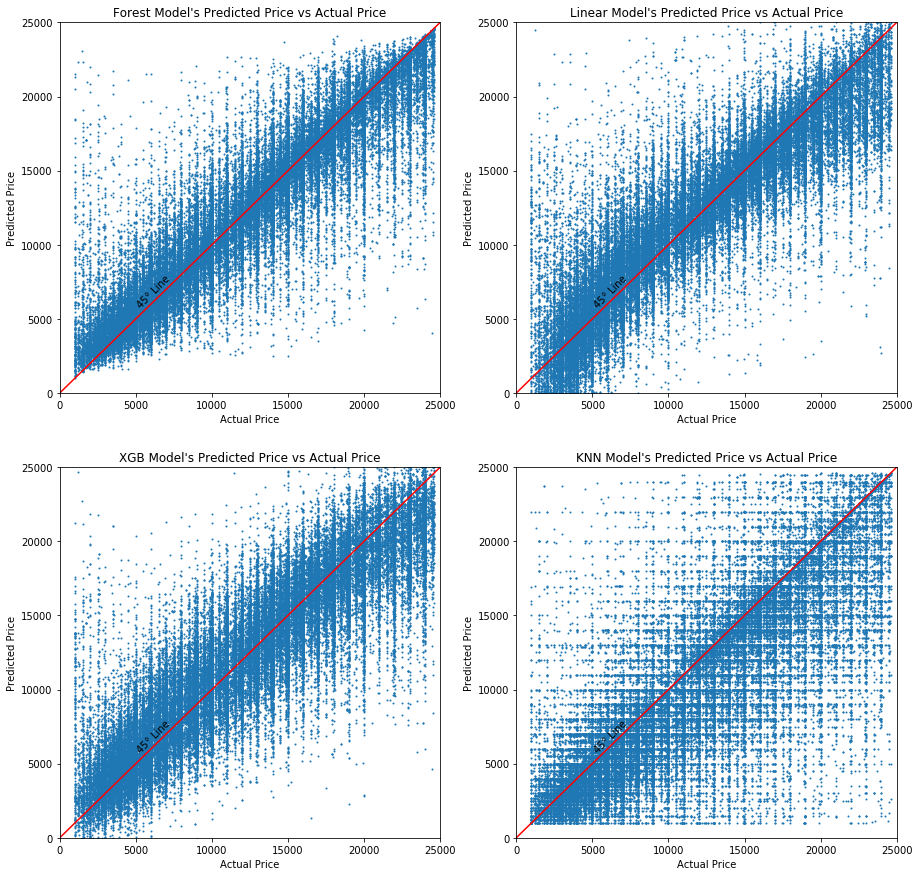

In [33]:
figNum = 0
predicted = [forest_y_predict_star, lin_model_preds, xgb_y_hat_star, kNN_y_predict_star]
name = ["Forest", "Linear", "XGB", "KNN"]
degree_sign= u'\N{DEGREE SIGN}'

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
for row in axs:
    for ax in row:
        pred = predicted[figNum]
        model = name[figNum]
        figTitle = model + " Model"
        
        ax.scatter(x=y_test, y=pred, s=1)
        ax.set_xlim(0,25000)
        ax.set_ylim(0,25000)
        ax.set_xlabel("Actual Price")
        ax.set_ylabel("Predicted Price".format(model))
        
        ax.set_title("{}'s Predicted Price vs Actual Price".format(figTitle))
        x = np.linspace(*ax.get_xlim())
        ax.plot(x, x, color="red")
        
        trans = ax.transAxes
        ax.text(0.2,0.23,"45{} Line".format(degree_sign) , rotation=45, transform = trans)
               
        figNum +=1
                
plt.show()

In the figure above, horizontal axis represents the actual price while vertical axis is representing the predicted price of a given model. The red line is 45 degree line. Therefore, a point on the red line corresponds to an observation for which the model perfectly predicts its price. For a better visual comparison, the axes ranges are the same.